In [1]:
import os
import sys
from datetime import datetime
from os.path import abspath
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
from hurst import compute_Hc

yf.pdr_override()

# Zipline imports
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         order_target,
                         order_value,
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore

# Ignore Warnings  
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)

# Todo list
1. Filter out stocks with hurst exponents
2. Build a Bollinger bands strategy
3. Use QuantStats to evaluate the Strategy

In [2]:
ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)
TICKER_FILE_PATH = f"{ROOT_DIR}/data/sp500_tickers.csv" 
PARQUET_FILE_PATH = f"{ROOT_DIR}/data/sp500_stock_data.parquet"

START_DATE = datetime(2018, 1, 1)
END_DATE = datetime(2022, 12, 31)

def calculate_years() -> int:
    return int((END_DATE - START_DATE).days / 365)

YEARS = calculate_years()

In [3]:
def load_tickers():
    sp500_df = pd.read_csv(TICKER_FILE_PATH)
    sp500_stock_data = pd.read_parquet(PARQUET_FILE_PATH) 
    return sp500_df['Ticker'].tolist(), sp500_stock_data

def is_not_null(close_data: pd.Series) -> bool:
    years = calculate_years()
    return len(close_data) >= 251.5 * years

def calculate_hurst_exponent(close_data: pd.Series) -> float: 
    H, c, data = compute_Hc(close_data, kind="price", simplified=True)
    return H

def hurst_filter(threshold: float = 0.5): # threshold < 0.5 --> mean reverting time series
    sp500_tickers, sp500_stock_data = load_tickers()
    filtered_tickers = []
    for ticker in sp500_tickers:
        if ticker in sp500_stock_data:
            close_data = sp500_stock_data[ticker][START_DATE : END_DATE][
                "close"
            ].dropna()
            if is_not_null(close_data):
                hurst_exponent = calculate_hurst_exponent(close_data)
                if hurst_exponent <= threshold:
                    filtered_tickers.append((ticker, hurst_exponent))

    filtered_tickers.sort(key=lambda x: x[1])
    top_n_tickers = [ticker for ticker, _ in filtered_tickers] # Top 10 stocks from the hurst filter
    # top_n_tickers = pd.DataFrame(top_n_tickers)
    return top_n_tickers

def calculate_atr(high_prices, low_prices, close_prices, period=14):
    high_low_diff = high_prices - low_prices
    high_close_diff = np.abs(high_prices - np.roll(close_prices, 1))
    low_close_diff = np.abs(low_prices - np.roll(close_prices, 1))
    true_range = np.maximum(high_low_diff, high_close_diff, low_close_diff)
    atr = np.mean(true_range[:period])
    for i in range(period, len(true_range)):
        atr = ((period - 1) * atr + true_range[i]) / period
    return atr
    

In [4]:
hurst_filtered = hurst_filter()

In [5]:
hurst_filtered

['BDX',
 'NI',
 'ED',
 'GEN',
 'D',
 'K',
 'AMGN',
 'CL',
 'GILD',
 'BIIB',
 'EVRG',
 'ATO',
 'SJM',
 'IFF',
 'INCY',
 'PNW',
 'DLR',
 'EIX',
 'CAH',
 'KMB',
 'VZ',
 'BAX',
 'CME',
 'CPB',
 'AEP',
 'CNC']

In [5]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2022-12-31') # Backtesting for 5 years

BASE_CAPITAL = 100_000

In [6]:
def plots(results):
    start = results.index[0]
    end = results.index[-1]
    benchmark = pdr.get_data_yahoo('^GSPC', start=start, end=end)['Adj Close'].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index  
    qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4))
              

# Without stop-loss or take-profit

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-31   2018-01-31
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          36.04%       92.18%
CAGR﹪                     4.42%        9.61%

Sharpe                     0.4          0.88
Prob. Sharpe Ratio         80.77%       97.8%
Smart Sharpe               0.34         0.76
Sortino                    0.54         1.4
Smart Sortino              0.47         1.21
Sortino/√2                 0.38         0.99
Smart Sortino/√2           0.33         0.86
Omega                      1.2          1.2

Max Drawdown               -33.92%      -18.92%
Longest DD Days            361          134
Volatility (ann.)          22.0%        16.65%
R^2                        0.53         0.53
Information Ratio          0.02         0.02
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-05-07,78,-18.920158,-15.446905
2,2022-08-26,2022-09-27,2022-11-29,96,-12.899870,-11.765774
3,2018-12-04,2018-12-24,2019-01-30,58,-9.910863,-7.793739
4,2020-07-28,2020-09-23,2020-11-03,99,-8.087440,-7.638014
5,2022-04-21,2022-06-14,2022-06-30,71,-7.385844,-7.218283


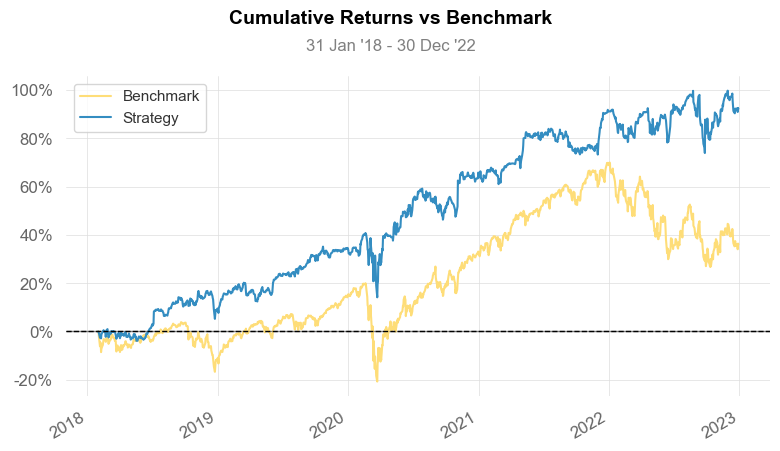

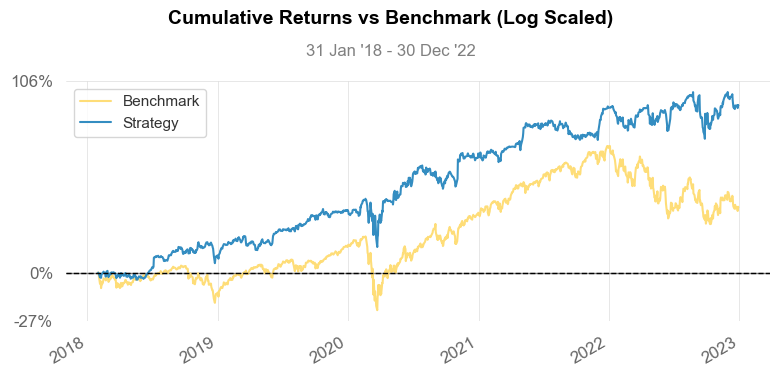

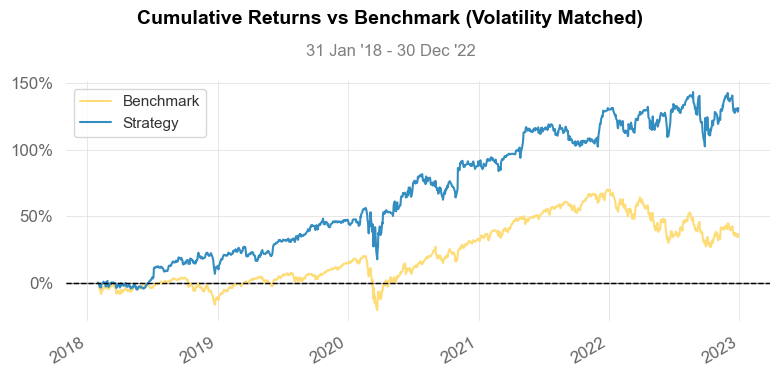

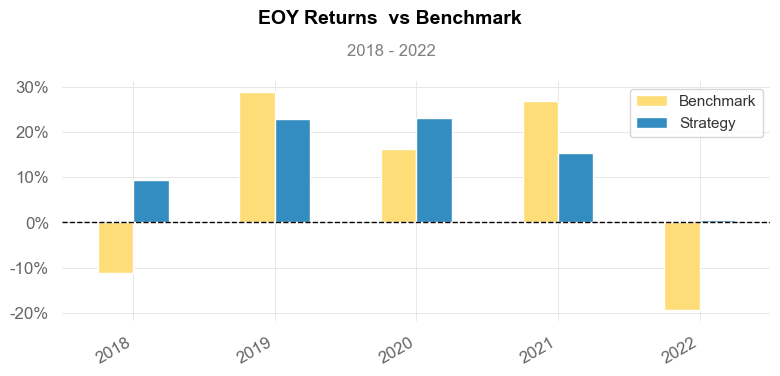

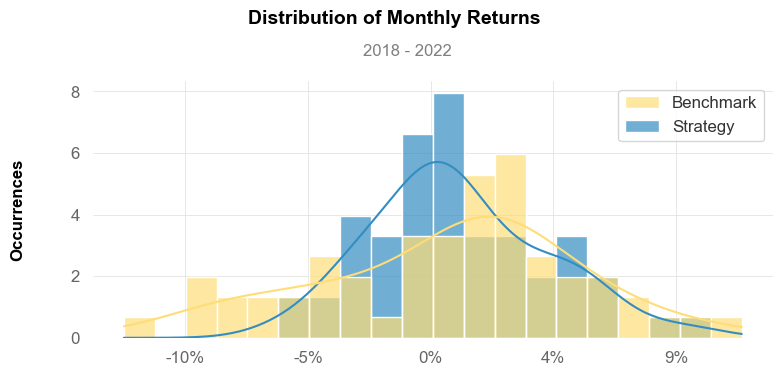

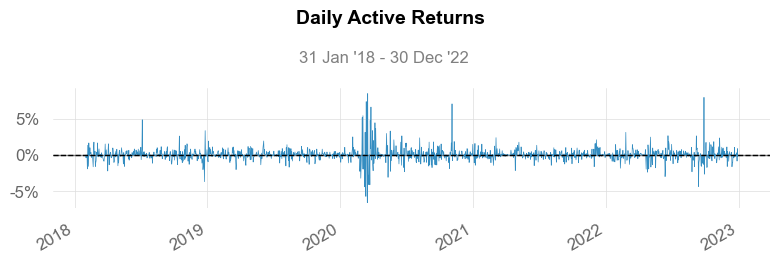

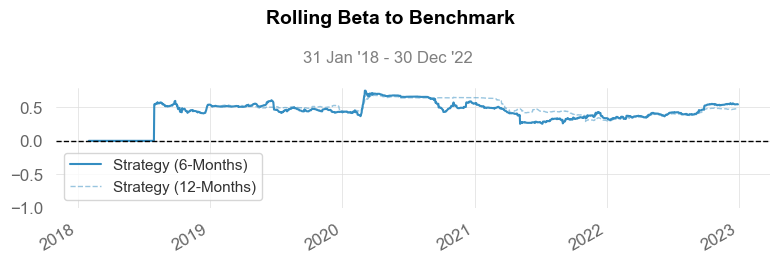

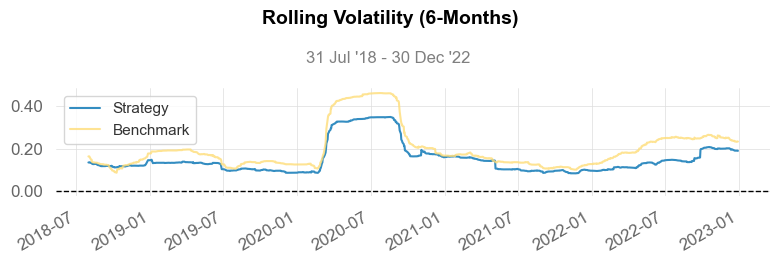

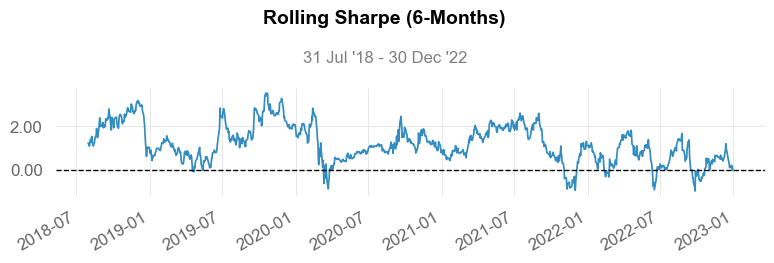

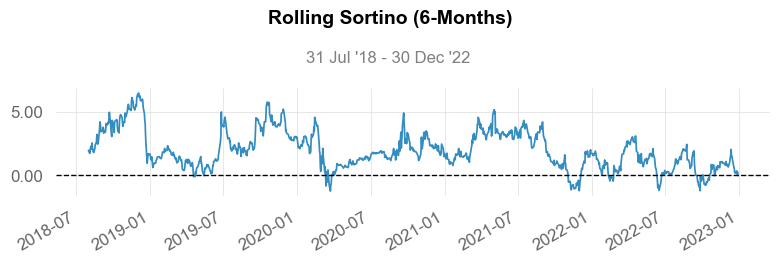

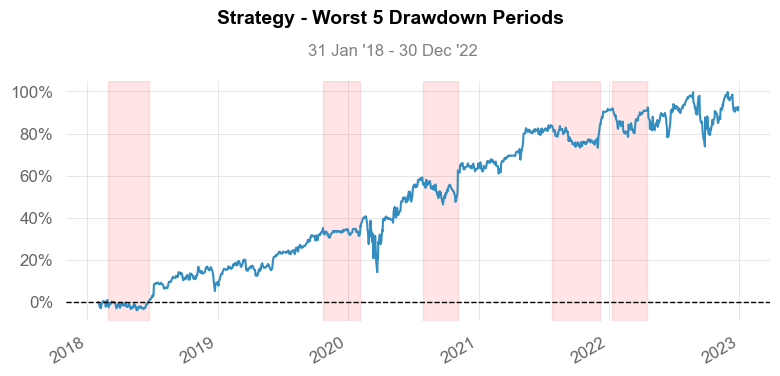

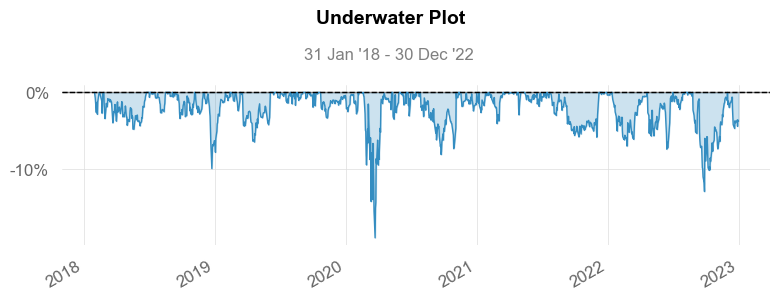

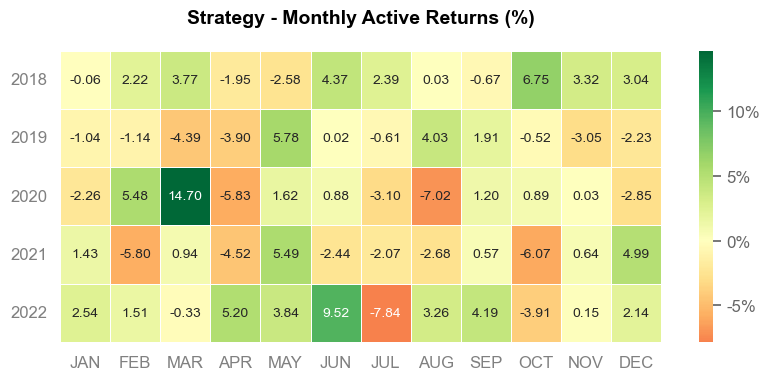

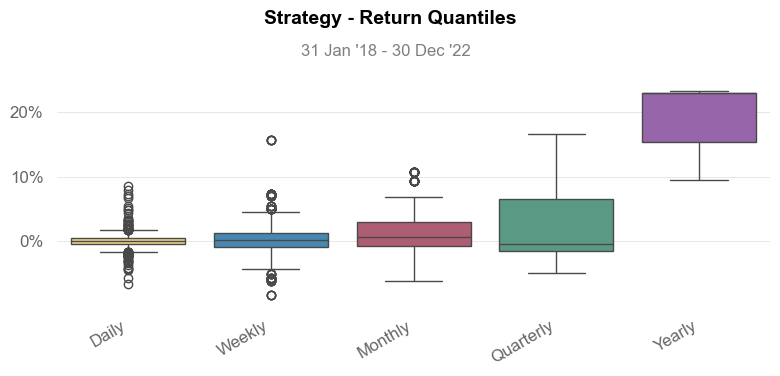

In [7]:
def initialize(context):
    context.idx = 0
    context.tickers = hurst_filtered
    context.bollinger_window = 20
    context.bollinger_dev = 1.5
    # context.stop_loss = 0.05 
    # context.take_profit  = 0.05
    # context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.buy_count, context.sell_count = 0, 0
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    context.idx += 1
    if context.idx < context.bollinger_window:
        return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.bollinger_window + 1, '1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        current_price = data.current(symbol(ticker), 'price')
        cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        amount = context.portfolio.positions[symbol(ticker)].amount

        # Generate signals based on Bollinger Bands, 
        if current_price < lower_band and ticker not in context.buy_stocks:        
            order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
            context.buy_count += 1
            context.buy_stocks.add(ticker)
        elif current_price > upper_band and ticker in context.buy_stocks:
            order_target_percent(symbol(ticker), 0)  # Sell Signal
            context.sell_count += 1
            context.buy_stocks.remove(ticker)
        
        # # stop-loss, and take-profit
        # if amount > 0:
        #     if current_price * (1 + context.take_profit) > cost_basis:
        #         order_target_percent(symbol(ticker), 0)
        #         context.profits += 1
        #     if current_price * (1 - context.stop_loss) < cost_basis:
        #         order_target_percent(symbol(ticker), 0)
        #         context.stops += 1
        # elif amount < 0:
        #     if  current_price * (1 - context.take_profit) < cost_basis:
        #         order_target_percent(symbol(ticker), 0)
        #         context.profits += 1
        #     if current_price * (1 + context.stop_loss) > cost_basis:
        #         order_target_percent(symbol(ticker), 0)
        #         context.stops += 1
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=sma,
            upper=upper_band,
            lower=lower_band,
            buy_count = context.buy_count, 
            sell_count = context.sell_count 
            # profits = context.profits,
            # stops = context.stops         
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp500bundle',
)
plots(results)

In [9]:
print(f"Average Daily Buys : {results.buy_count.sum()/(5*252)}")
print(f"Average Monthly Buys : {results.buy_count.sum()/(5*12)}")
print(f"Average Annual Buys : {results.buy_count.sum()/5}")
print(f"Average Daily Sells : {results.sell_count.sum()/(5*252)}")
print(f"Average Monthly Sells : {results.sell_count.sum()/(5*12)}")
print(f"Average Annual Sells : {results.sell_count.sum()/5}")

Average Daily Buys : 291.0531746031746
Average Monthly Buys : 6112.116666666667
Average Annual Buys : 73345.4
Average Daily Sells : 278.9047619047619
Average Monthly Sells : 5857.0
Average Annual Sells : 70284.0


## Summary (Without Stoploss): 
1. **Promising Performance:**
    - The backtest without a stop loss shows promising results, performing comparably to the benchmark.
    - Noteworthy resilience during the challenging Covid-19 period. Could be due to the initial boost at the end of 2018.
2. **Volatility-Driven Outperformance:**
    - Outperforms the benchmark when volatility is matched.
    - Positive signs from metrics like Volatility, Sharpe ratio, and Sortino ratio.
3. **Continuous Market Exposure:**
    - Lack of a stop loss or take profit exposes the strategy to the market at all times.
    - Unfavorable for a mean-reverting strategy, as mean reverting strategies perform in the market for a short while.
4. **Overtrading Concerns:**
    - High average buy and sell counts indicate potential overtrading.
    - Overtrading could negatively impact overall performance in the lon run.
5. **Future Concerns:**
    - Implement a adaptive stop-loss mechanism to manage downside risk.
    - Optimize trade frequency to enhance the strategy's robustness and risk-adjusted returns.

# With ATR Stop loss and Take profit

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-31   2018-01-31
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       94.0%

Cumulative Return          36.04%       47.58%
CAGR﹪                     4.42%        5.62%

Sharpe                     0.4          0.72
Prob. Sharpe Ratio         80.77%       94.87%
Smart Sharpe               0.39         0.71
Sortino                    0.54         1.14
Smart Sortino              0.54         1.12
Sortino/√2                 0.38         0.8
Smart Sortino/√2           0.38         0.79
Omega                      1.16         1.16

Max Drawdown               -33.92%      -13.01%
Longest DD Days            361          317
Volatility (ann.)          22.0%        11.96%
R^2                        0.27         0.27
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-09-17,2018-12-24,2019-07-30,317,-13.008356,-10.347167
2,2020-07-20,2020-09-23,2021-01-27,192,-12.480020,-11.345239
3,2020-02-20,2020-03-12,2020-03-27,37,-11.541786,-10.113806
4,2021-06-18,2021-11-30,2022-04-19,306,-11.216480,-10.463636
5,2022-04-21,2022-11-11,2022-12-30,254,-10.665781,-10.496221


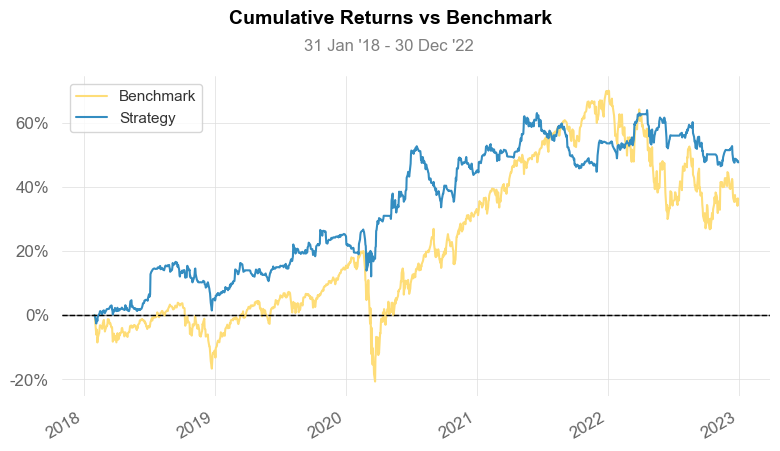

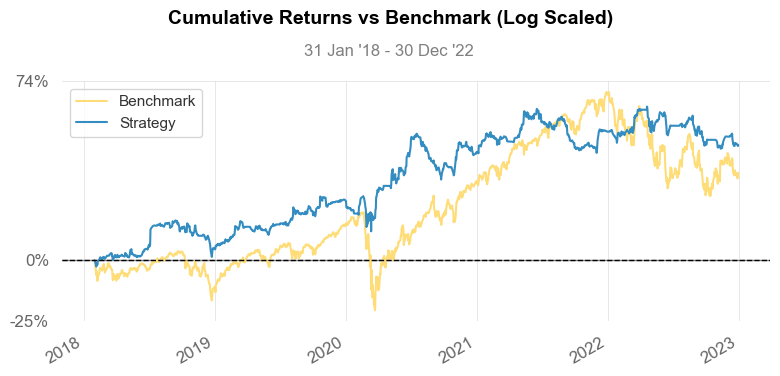

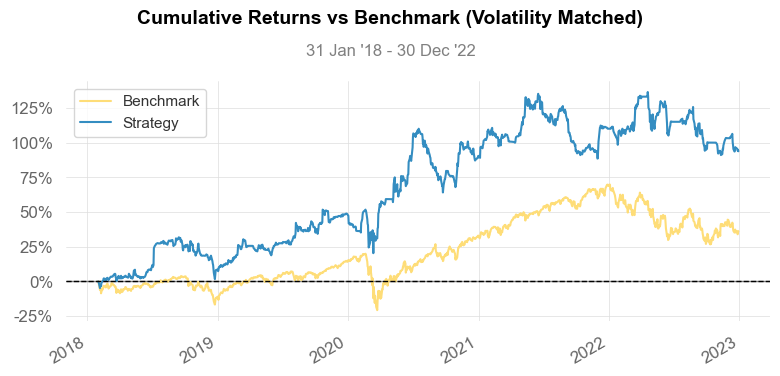

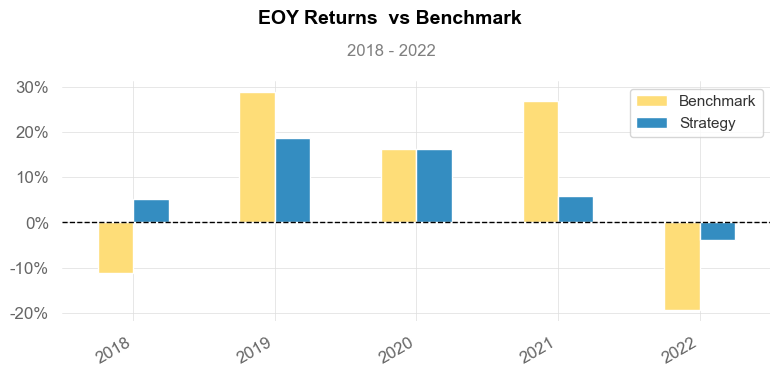

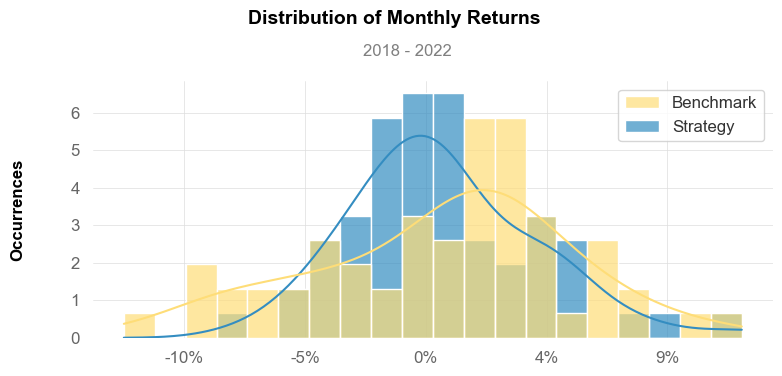

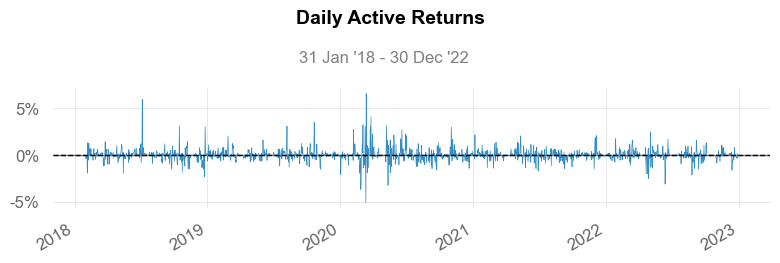

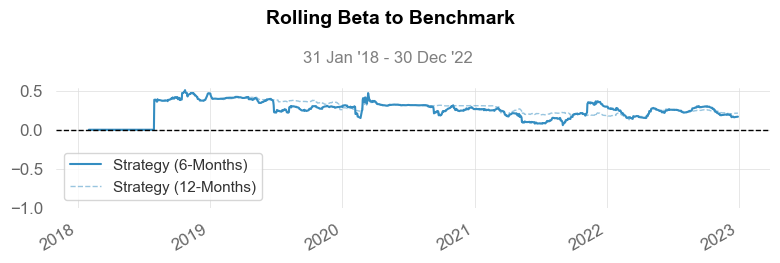

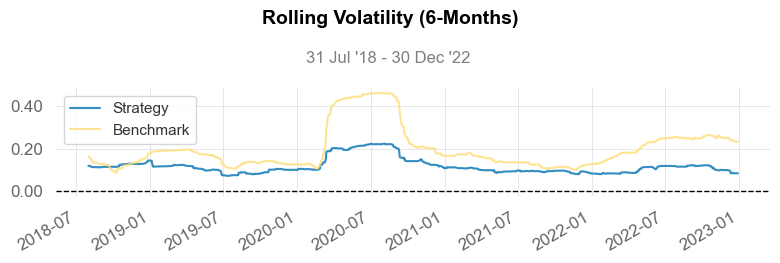

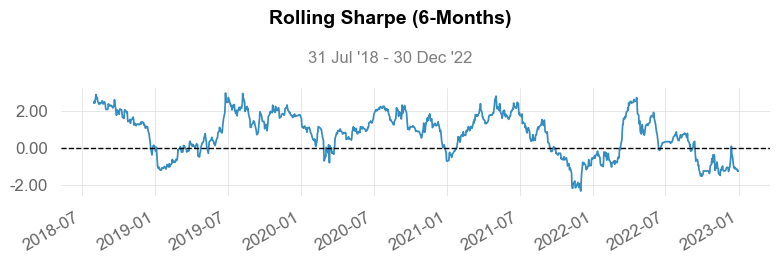

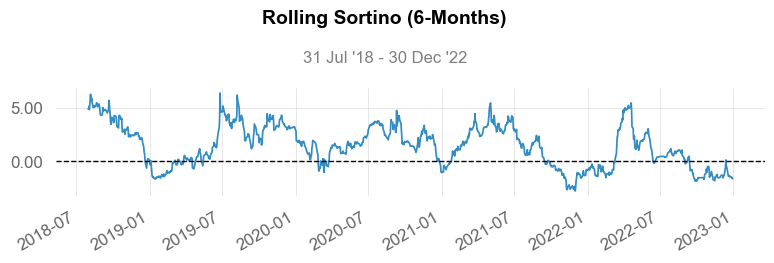

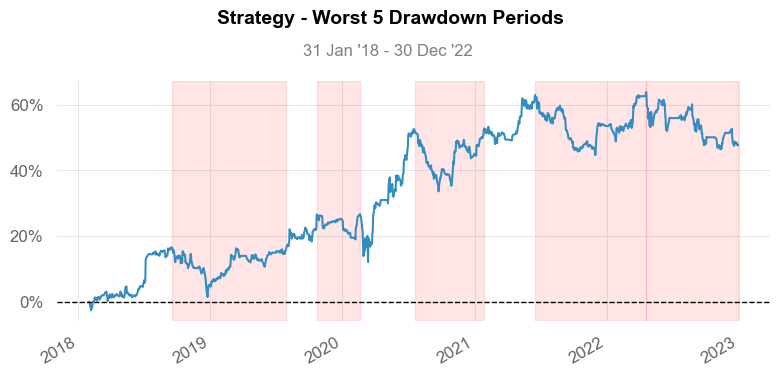

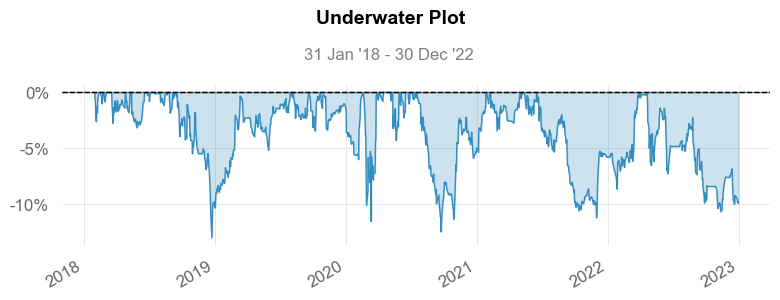

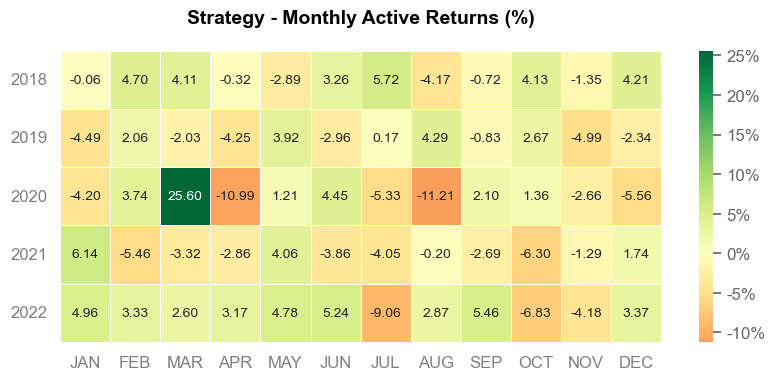

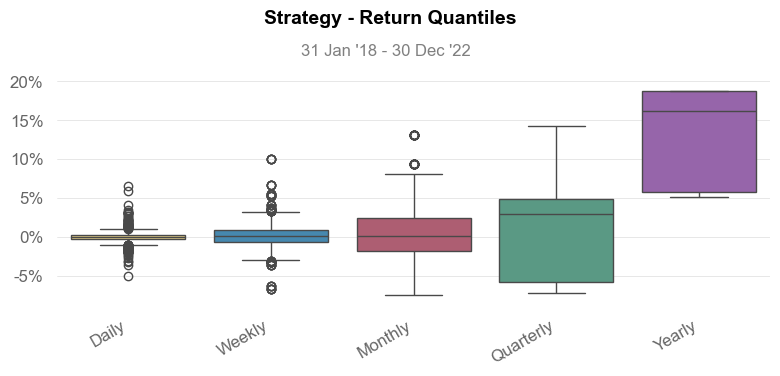

In [10]:
def initialize(context):
    context.idx = 0
    context.tickers = hurst_filtered
    context.bollinger_window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05 
    context.take_profit  = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    context.idx += 1
    if context.idx < context.bollinger_window:
        return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.bollinger_window + 1, '1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        current_price = data.current(symbol(ticker), 'price')
        cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        amount = context.portfolio.positions[symbol(ticker)].amount

        # Generate signals based on Bollinger Bands, 
        if current_price < lower_band and ticker not in context.buy_stocks:        
            order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
            context.buy_count += 1
            context.buy_stocks.add(ticker)
        elif current_price > upper_band and ticker in context.buy_stocks:
            order_target_percent(symbol(ticker), 0)  # Sell Signal
            context.sell_count += 1
            context.buy_stocks.remove(ticker)
        
        # stop-loss, and take-profit
        high = data.history(symbol(ticker), 'high', context.atr_window + 1, '1d')
        low = data.history(symbol(ticker), 'low', context.atr_window + 1, '1d')
        close = data.history(symbol(ticker), 'close', context.atr_window + 1, '1d')
        atr = calculate_atr(high, low, close, context.atr_window)
        if amount > 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
            elif current_price < cost_basis - (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
        elif amount < 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
            elif current_price <= cost_basis -  (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=sma,
            upper=upper_band,
            lower=lower_band,
            buy_count = context.buy_count, 
            sell_count = context.sell_count, 
            profits = context.profits,
            stops = context.stops         
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp500bundle',
)
plots(results)

In [43]:
print(f"Average Daily Buys : {results.buy_count.sum()/(5*252)}")
print(f"Average Monthly Buys : {results.buy_count.sum()/(5*12)}")
print(f"Average Annual Buys : {results.buy_count.sum()/5}")
print(f"Average Daily Sells : {results.sell_count.sum()/(5*252)}")
print(f"Average Monthly Sells : {results.sell_count.sum()/(5*12)}")
print(f"Average Annual Sells : {results.sell_count.sum()/5}")

Average Daily Buys : 316.0904761904762
Average Monthly Buys : 6637.9
Average Annual Buys : 79654.8
Average Daily Sells : 302.5968253968254
Average Monthly Sells : 6354.533333333334
Average Annual Sells : 76254.4


## Summary (With ATR Stoploss): 
1. **Performance Comparison:**
    - The tearsheet indicates that the strategy with ATR stop loss performs less favorably than the strategy without stop loss but remains competitive with the benchmark.
2. **Portfolio Resilience during Covid:**
    - Despite a decent portfolio performance during the Covid period, it's important to note that this may be influenced by the initial boost in 2018.
3. **Volatility-Driven Success:**
    - Demonstrates strong performance when volatility is matched, showcasing positive signs in metrics such as Volatility, Sharpe ratio, and Sortino ratio.
4. **Time-in-Market and Overtrading:**
    - Even with ATR set at 1.5, the strategy maintains market exposure for 94%, which is suboptimal for a mean-reverting strategy.
    - High average buy and sell counts persist, signaling potential overtrading issues.
5. **Future Concerns:**
    - Reevaluate the ATR stop loss setting to find an optimal balance between risk management and strategy performance.
    - Address overtrading concerns by optimizing trade frequency and refining entry/exit criteria.

### Backtesting with pervious data on a latest situation shows a more accurate picture of the backtest.

In [16]:
START_DATE = datetime(2018, 1, 1)
END_DATE = datetime(2022, 12, 31) # Taking data from 2018-2022
hurst_filtered = hurst_filter()
START_DATE = pd.Timestamp('2023-01-01')
END_DATE = pd.Timestamp('2023-12-31') # Backtesting for year 2023

BASE_CAPITAL = 100_000

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-02-01   2023-02-01
End Period                 2023-12-29   2023-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       94.0%

Cumulative Return          17.01%       -7.77%
CAGR﹪                     12.7%        -5.97%

Sharpe                     1.41         -1.03
Prob. Sharpe Ratio         91.1%        15.79%
Smart Sharpe               1.36         -0.99
Sortino                    2.14         -1.34
Smart Sortino              2.05         -1.29
Sortino/√2                 1.51         -0.94
Smart Sortino/√2           1.45         -0.91
Omega                      0.82         0.82

Max Drawdown               -10.28%      -11.94%
Longest DD Days            122          319
Volatility (ann.)          12.73%       8.25%
R^2                        0.11         0.11
Information Ratio          -0.13        -0.13
Calmar        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-02-14,2023-10-31,2023-12-29,319,-11.942585,-11.455067
2,2023-02-08,2023-02-09,2023-02-10,3,-1.526423,-0.570067
3,2023-02-06,2023-02-06,2023-02-06,1,-0.019309,NaN


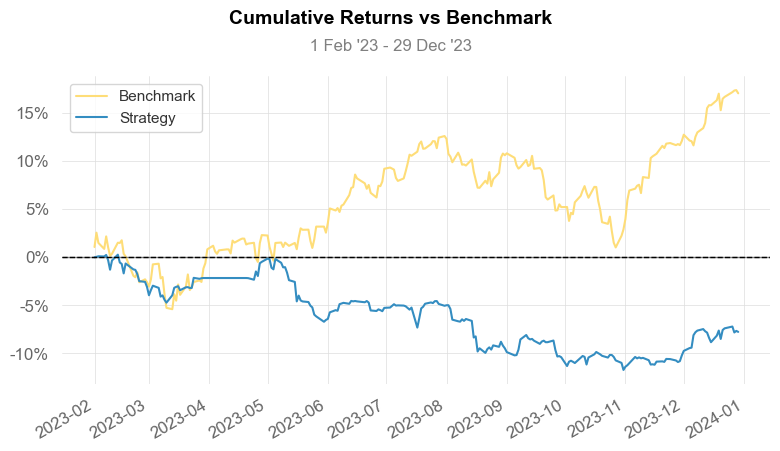

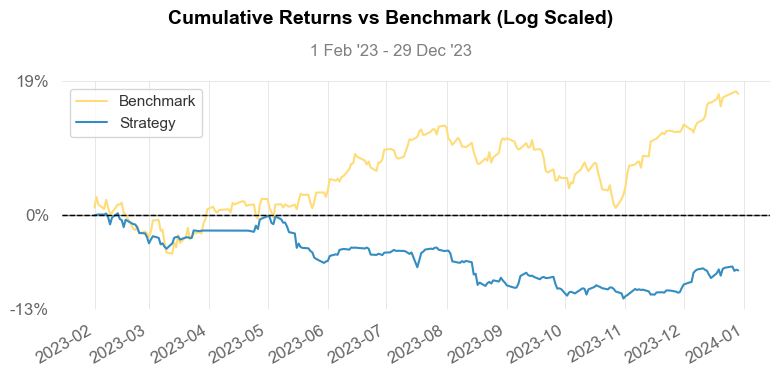

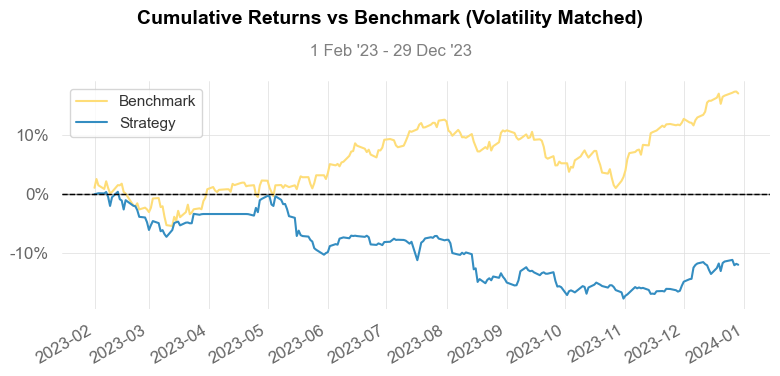

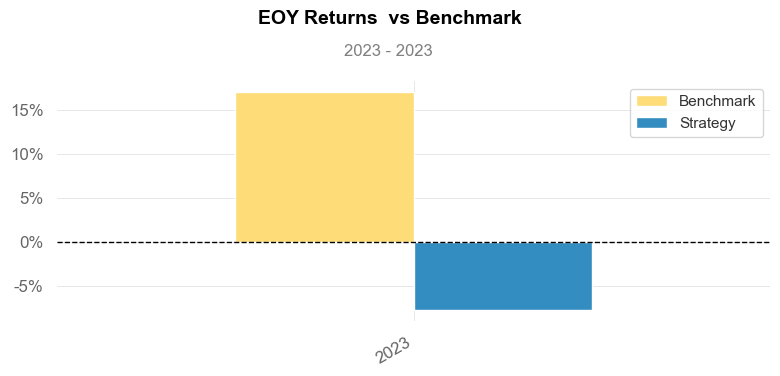

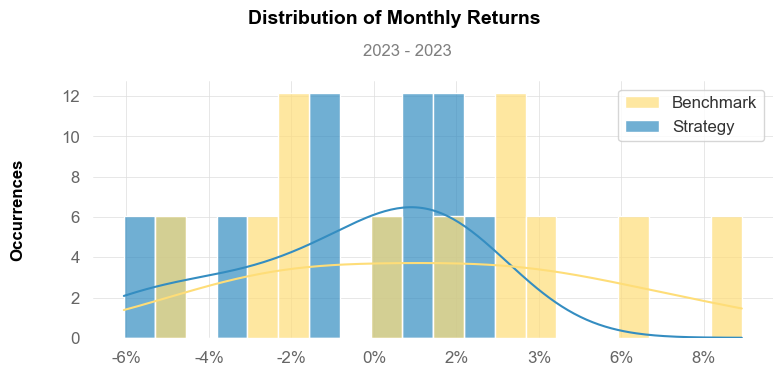

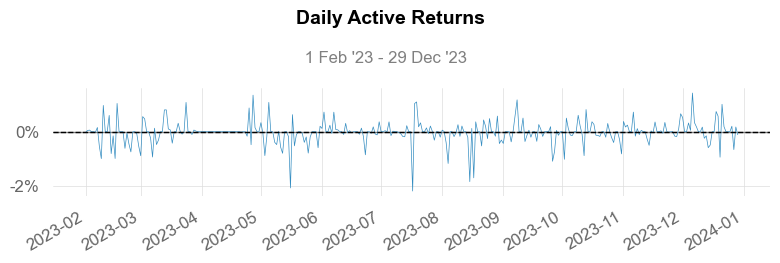

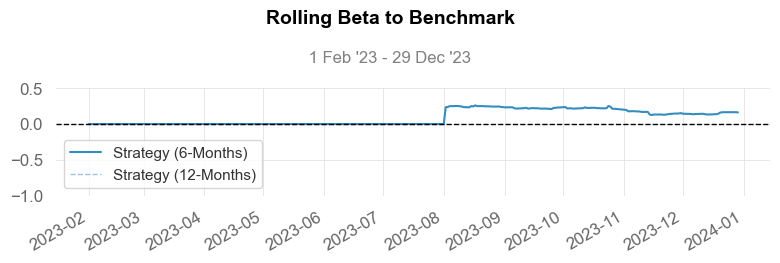

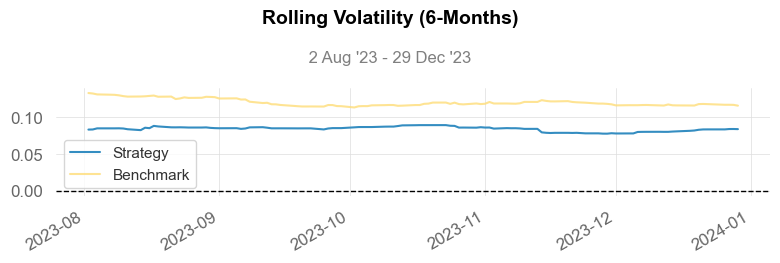

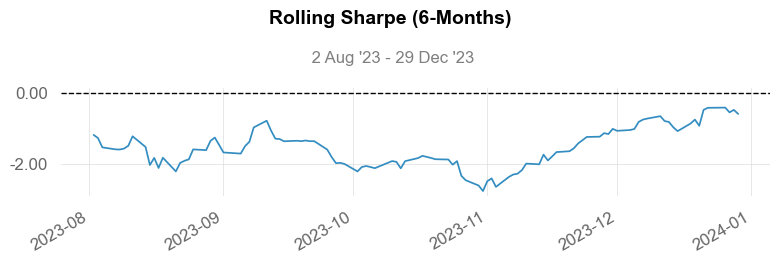

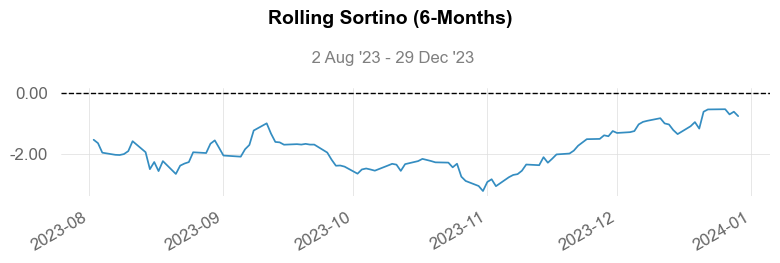

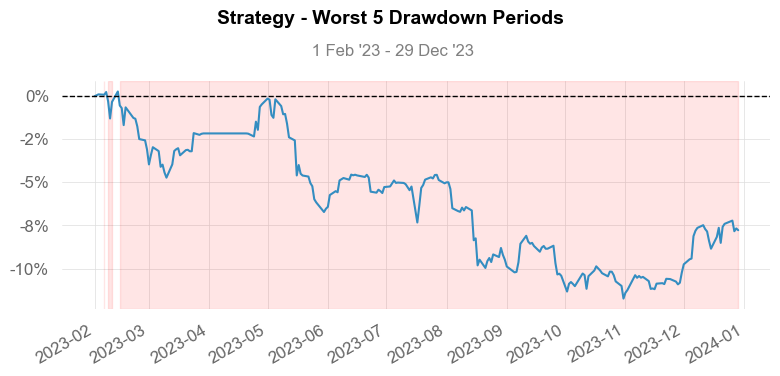

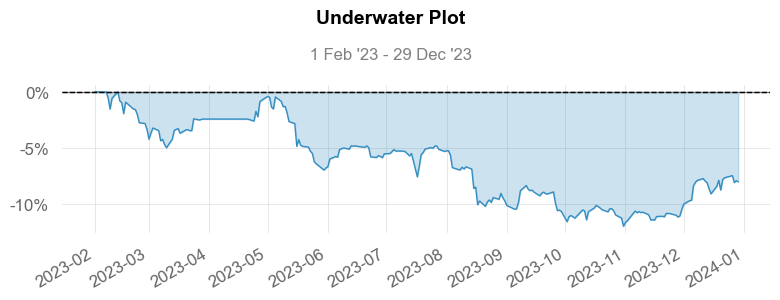

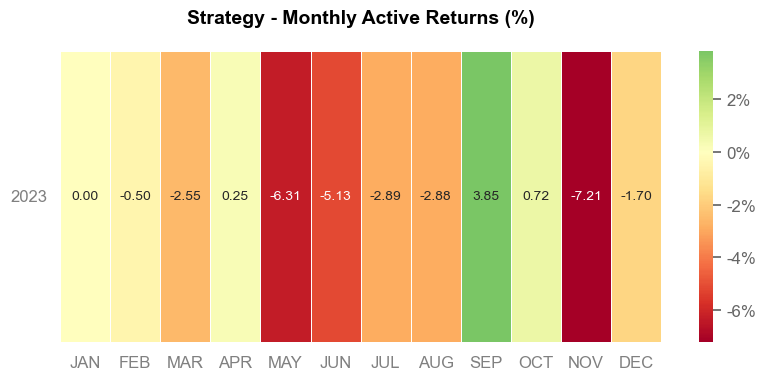

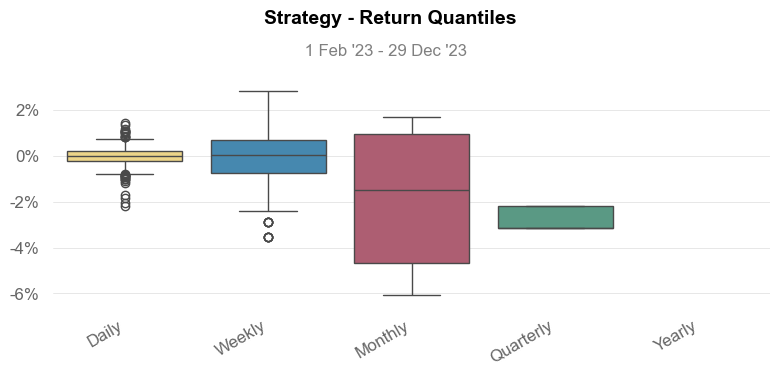

In [17]:
def initialize(context):
    context.idx = 0
    context.tickers = hurst_filtered
    context.bollinger_window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05 
    context.take_profit  = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    context.idx += 1
    if context.idx < context.bollinger_window:
        return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.bollinger_window + 1, '1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        current_price = data.current(symbol(ticker), 'price')
        cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        amount = context.portfolio.positions[symbol(ticker)].amount

        # Generate signals based on Bollinger Bands, 
        if current_price < lower_band and ticker not in context.buy_stocks:        
            order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
            context.buy_count += 1
            context.buy_stocks.add(ticker)
        elif current_price > upper_band and ticker in context.buy_stocks:
            order_target_percent(symbol(ticker), 0)  # Sell Signal
            context.sell_count += 1
            context.buy_stocks.remove(ticker)
        
        # stop-loss, and take-profit
        high = data.history(symbol(ticker), 'high', context.atr_window + 1, '1d')
        low = data.history(symbol(ticker), 'low', context.atr_window + 1, '1d')
        close = data.history(symbol(ticker), 'close', context.atr_window + 1, '1d')
        atr = calculate_atr(high, low, close, context.atr_window)
        if amount > 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
            elif current_price < cost_basis - (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
        elif amount < 0:
            if current_price >= cost_basis + (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.stops += 1
            elif current_price <= cost_basis -  (atr * context.atr_dev):
                order_target_percent(symbol(ticker), 0)
                context.profits += 1
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=sma,
            upper=upper_band,
            lower=lower_band,
            buy_count = context.buy_count, 
            sell_count = context.sell_count, 
            profits = context.profits,
            stops = context.stops         
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp500bundle',
)
plots(results)

# Blind Test Scenario

In a blind test scenario, the Hurst filter is trained on historical data from 2018 to 2022, and the strategy is applied in 2023. This simulates a situation where someone discovers the strategy in 2022 and applies it in the subsequent year.

Results from this scenario indicate suboptimal performance:
- The backtest yields poor returns, highlighting the strategy's limited effectiveness in this specific time frame.
- Metrics such as volatility, Sharpe ratio, and Sortino ratio show a decline, signaling unfavorable outcomes.

To address these challenges and improve the strategy's performance in blind tests:
1. **Optimize Historical Data for Hurst Filter:**
   - Reevaluate the historical data used by the Hurst filter to ensure it captures relevant patterns.
   - Fine-tune the back years to enhance the filter's effectiveness.

2. **Implement Yearly Rebalancing:**
   - Introduce a yearly rebalancing mechanism for the stocks selected by the Hurst filter.
   - Regularly reassessing the portfolio aligns with market dynamics and could lead to improved results.


# Conclusion 
1. **Challenges in Optimization:**
    - Running a backtest optimization proved challenging, with each iteration taking 2-3 minutes or more.
    - The time-intensive nature of the process impedes rigorous optimization using grid search or other methods, requiring days to complete.
2. **Performance Without Stop Loss:**
    - The strategy displayed promise without a stop loss but fell short of expectations when stop losses were introduced.
3. **Optimization Ideas:**
    - Explore alternative filters (Previous ADF test yielded unsatisfactory results).
    - Investigate other mean-reverting strategies like RSI.
    - Consider yearly rebalancing of stocks using the Hurst filter.
    - Explore more adaptive stop-loss strategies for improved risk management.

# Future Ideas

1. **Integration with Neural Networks:**
   - Consider integrating simple strategies with neural networks to enhance predictive power.
   - Neural networks can provide predictive results, potentially improving the strategy's overall performance.
   - [Reference](https://www.sciencedirect.com/science/article/abs/pii/S0927539897000224)

2. **Sector-Based Analysis:**
   - Explore the application of the Hurst filter to industry groups and sectors.
   - Trends within industry segments often persist after detection by simple momentum indicators.
   - This approach may yield valuable insights and improve strategy performance.
   - [Reference](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.1990.tb05110.x)

3. **Usage of Kalman filter:**
   - Kalman filters are good for state estimation and noise reduction. So these filters could be used to impact the backtest results

These future ideas aim to leverage advanced techniques and sector-based insights to further enhance the strategy's predictive capabilities and overall effectiveness.